# Workshop 4: Fine-Tuning and Evaluating NLP Models (BERT vs LSTM) on Tripadvisor Reviews

In this workshop, we'll compare the performance of BERT, DistilBERT, and LSTM models on the Tripadvisor dataset. We'll explore model performance with different training configurations, learning curves, dropout rates, and feature engineering. The goal is to observe how these models perform and optimize based on error analysis and sentiment/sarcasm detection.


## Objectives:

1. Fine-tune BERT, DistilBERT, and LSTM models on the Tripadvisor dataset.
2. Explore the impact of different learning rates, epochs, batch sizes, and dropout rates on model performance.
3. Compare training and validation losses for each model.
4. Use feature engineering techniques (sentiment and sarcasm analysis) to improve model performance.

The use of BERT needs a GPU, therefore we will need to use Colab that has free GPU to make the tests.

In [1]:
!pip install datasets transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.7 MB/s eta 0:00:00


# Step 0:  Introduction to BERT and Hugging Face

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model designed to understand the context of words in a sentence by looking at both directions. It is a versatile tool for natural language processing (NLP) tasks such as classification, named entity recognition, and more. In this example, we will use BERT along with the Hugging Face library to tokenize and process a text dataset for sentiment analysis.

**Key Concepts**:
- **Tokenization**: The tokenizer breaks down sentences into tokens that BERT can understand. BERT uses special tokens such as `[CLS]`, `[SEP]`, and `[PAD]`.
  - `[CLS]`: The first token of every input sequence, representing the entire sequence, typically used for classification tasks.
  - `[SEP]`: A token used to separate distinct sequences (useful in question-answering or sentence-pair tasks).
  - `[PAD]`: A token used to pad sequences to the same length.
- **Word Embeddings**: Each token has an associated embedding that captures its meaning. Embeddings are context-dependent, meaning the representation for a word can change depending on the context.

## Basic Example


In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer
import tensorflow as tf

tripadvisor_reviews = load_dataset('argilla/tripadvisor-hotel-reviews').shuffle(seed=42)

# Limit dataset size to speed up training
train_dataset = tripadvisor_reviews['train'].select(range(2500))
valid_dataset = tripadvisor_reviews['train'].select(range(2500, 3000))
test_dataset = tripadvisor_reviews['train'].select(range(3000, 4000))

# Tokenize dataset for BERT models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def preprocess_data(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)

train_tokenized = train_dataset.map(preprocess_data, batched=True)
valid_tokenized = valid_dataset.map(preprocess_data, batched=True)
test_tokenized = test_dataset.map(preprocess_data, batched=True)

# Check the tokenized representation
print("Tokenized Example:")
example = train_tokenized[1]
text_tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
print("Text Tokens:", text_tokens)
print("Input IDs:", example['input_ids'])
print("Attention Mask:", example['attention_mask'])

Tokenized Example:
Text Tokens: ['[CLS]', '10', '/', '10', 'bahia', 'effort', 'make', 'vacation', 'dreams', 'come', 'true', ',', 'girlfriend', 'just', 'got', 'plane', 'bahia', 'pri', '##nc', '##ipe', 'punta', 'can', '##a', 'despite', 'fact', 'delayed', 'half', 'hour', 'departing', 'punta', 'can', '##a', ',', 'amazing', '1', 'week', 'vacation', 'excited', 'write', 'review', 'fall', 'asleep', 'tonight', '.', 'we', 'originated', 'toronto', 'canada', ',', 'took', 'sept', '4', 'air', 'trans', '##at', 'flight', 'punta', 'can', '##a', ',', 'smooth', 'flight', 'weather', 'great', 'punta', 'can', '##a', 'arrived', ',', 'soon', 'greeted', 'enthusiastic', 'entertainer', '##s', 'pictures', 'taken', 'beautiful', 'ladies', 'pictures', 'available', 'pick', 'depart', 'punta', 'can', '##a', 'airport', 'week', 'later', ',', 'no', 'trouble', 'finding', 'transfer', 'bus', 'resort', 'provided', 'room', 'keys', 'introductory', 'documents', 'way', 'resort', ',', '1', '/', '2', 'hour', 'bump', '##y', 'ride', 

**Explanation of Tokenizer Outputs**:
- **Input IDs**: A numerical representation of each token in the input sentence.
- **Attention Mask**: Indicates which tokens should be attended to (1) or ignored (0). It helps in distinguishing the actual content from padded tokens.

**Additional Focus: CLS and SEP Tokens**:
- The `[CLS]` token is always at the start of the sequence and is used by BERT for classification tasks.
- The `[SEP]` token is added at the end of each sequence to mark the boundary.

## Output Tokens from BERT

The output from BERT includes embeddings for all the tokens in the input sequence, including `[CLS]`, individual word tokens, and `[SEP]`. Each token has its corresponding vector representation (embedding), which captures the context of the token within the sequence.

In [ ]:
from transformers import TFBertModel

# Load the BERT model without the classification head
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
inputs = tokenizer("This is a positive review!", return_tensors='tf', padding=True, truncation=True, max_length=32)

# Get the embeddings for each token in the input sequence
outputs = bert_model(**inputs)
last_hidden_states = outputs.last_hidden_state

print(inputs['input_ids'].shape)
print(last_hidden_states.shape)
text_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("Tokens:")
print(text_tokens)

(1, 8)
(1, 8, 768)
Tokens:
['[CLS]', 'this', 'is', 'a', 'positive', 'review', '!', '[SEP]']


In [ ]:
# Display the embeddings for each token
print("Embeddings for each token in the input sequence:")
for idx, token_id in enumerate(inputs['input_ids'][0]):
    token = tokenizer.convert_ids_to_tokens(int(token_id))
    print(f"Token: {token}, Embedding: {last_hidden_states[0][idx]}")

Embeddings for each token in the input sequence:
Token: [CLS], Embedding: [ 1.58780310e-02 -5.50993867e-02 -9.29549336e-03 -4.74357545e-01
 -1.21907808e-01 -8.43611658e-01  1.04626462e-01  4.53039289e-01
  1.64476648e-01 -4.64804135e-02 -6.04648888e-02 -2.32461020e-02
  4.85258251e-02  5.12875319e-01  3.65199000e-01 -1.19931214e-02
 -2.95360386e-01  4.57208455e-01  3.16885442e-01 -3.87691647e-01
 -9.09993351e-02 -3.90719980e-01  4.81009074e-02  7.41241351e-02
 -9.26260725e-02 -2.78501242e-01  1.41328260e-01 -2.85173088e-01
 -2.37325039e-02 -1.02678567e-01  7.78779667e-03  3.43899310e-01
 -4.99401331e-01  1.20984741e-01 -6.23092148e-03  2.21507967e-01
  3.47214490e-02  1.98211119e-01 -8.64284113e-03  2.08223924e-01
  3.77938002e-02 -1.29606485e-01  3.15178424e-01  2.01391459e-01
  1.47634640e-01 -2.02161759e-01 -2.67524385e+00 -3.21498454e-01
  4.55426946e-02 -1.66105852e-01  3.90609324e-01  8.28206390e-02
  1.81346655e-01  5.00297844e-02 -3.01501900e-03  2.19829082e-01
 -5.77030718e-01

**Explanation**:
- The output `last_hidden_state` contains the embeddings for each token in the input sequence.
- Each embedding is a vector that represents the context of the corresponding token.
- The embedding for the `[CLS]` token is used for classification tasks as it captures information from the entire sequence.


In [ ]:
# Focusing on the CLS Token for Classification
cls_embedding = last_hidden_states[0][0]  # The embedding for the [CLS] token
print("\nEmbedding for [CLS] token:")
print(cls_embedding)


Embedding for [CLS] token:
tf.Tensor(
[ 1.58780310e-02 -5.50993867e-02 -9.29549336e-03 -4.74357545e-01
 -1.21907808e-01 -8.43611658e-01  1.04626462e-01  4.53039289e-01
  1.64476648e-01 -4.64804135e-02 -6.04648888e-02 -2.32461020e-02
  4.85258251e-02  5.12875319e-01  3.65199000e-01 -1.19931214e-02
 -2.95360386e-01  4.57208455e-01  3.16885442e-01 -3.87691647e-01
 -9.09993351e-02 -3.90719980e-01  4.81009074e-02  7.41241351e-02
 -9.26260725e-02 -2.78501242e-01  1.41328260e-01 -2.85173088e-01
 -2.37325039e-02 -1.02678567e-01  7.78779667e-03  3.43899310e-01
 -4.99401331e-01  1.20984741e-01 -6.23092148e-03  2.21507967e-01
  3.47214490e-02  1.98211119e-01 -8.64284113e-03  2.08223924e-01
  3.77938002e-02 -1.29606485e-01  3.15178424e-01  2.01391459e-01
  1.47634640e-01 -2.02161759e-01 -2.67524385e+00 -3.21498454e-01
  4.55426946e-02 -1.66105852e-01  3.90609324e-01  8.28206390e-02
  1.81346655e-01  5.00297844e-02 -3.01501900e-03  2.19829082e-01
 -5.77030718e-01  6.20386243e-01 -2.54801005e-01  7

**Explanation**:
- The output `last_hidden_state` contains the embeddings for each token in the input sequence.
- Each embedding is a vector that represents the context of the corresponding token.
- The embedding for the `[CLS]` token is used for classification tasks as it captures information from the entire sequence.

## BERT Model and CLS Token

BERT is a versatile model that uses transformer encoders to learn the context of words in a sequence. When using BERT for classification, the `[CLS]` token is particularly important as its embedding is used for the final prediction. Here is a basic example of how to use BERT for classification.


In [ ]:
from transformers import TFBertForSequenceClassification

num_labels = 4

# Load a pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Forward Pass Example
inputs = tokenizer("This is a positive review!", return_tensors='tf')
outputs = model(**inputs, output_hidden_states=True)

# Extracting logits from the model output
logits = outputs.logits
print("Logits:", logits)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logits: tf.Tensor([[ 0.03563138 -0.09488032  0.00080631  0.39962325]], shape=(1, 4), dtype=float32)


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_339 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 109485316 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
outputs.hidden_states[-1].shape

TensorShape([1, 8, 768])

In [ ]:
(768 + 1) * num_labels

3076

**Explanation**:
- **CLS Token Output**: The embedding of the `[CLS]` token represents the entire sentence and is used for classification.
- **Logits**: These are the raw, unnormalized predictions from the model, which can be converted into probabilities for classification.

## Context-Dependent Embeddings

One of the strengths of BERT is its ability to provide different embeddings for the same word based on its context. For example, the word "bank" in the context of "river bank" will have a different embedding compared to "financial bank".


In [ ]:
sentences = [
    "He went to the river bank to relax.",
    "She deposited money in the bank."
]

# Tokenize the sentences
tokenized_inputs = tokenizer(sentences, return_tensors='tf', padding=True, truncation=True)

# Get embeddings from BERT
outputs = bert_model(**tokenized_inputs)
last_hidden_states = outputs.last_hidden_state

# The embeddings for the word 'bank' will be different based on the context in the sentence
print("\nEmbeddings for 'bank' in different contexts (reduced to 10 first elements):")
for idx, sentence in enumerate(sentences):
    token_idx = tokenized_inputs['input_ids'][idx].numpy().tolist().index(tokenizer.convert_tokens_to_ids('bank'))
    print(f"Sentence: {sentence}, Embedding for 'bank': {last_hidden_states[idx][token_idx][:10]}")


Embeddings for 'bank' in different contexts (reduced to 10 first elements):
Sentence: He went to the river bank to relax., Embedding for 'bank': [ 0.05637257 -0.5002256  -0.16945659 -0.31698155 -0.2544984   0.14145659
  0.42666623  0.96855646 -0.01609945 -0.69129646]
Sentence: She deposited money in the bank., Embedding for 'bank': [ 0.30310327 -0.366874   -0.3563673   0.14485882  1.0418965   0.16947813
 -0.45562223  0.73691183 -0.0700895  -0.08619163]


## Step 1: Load and Preprocess the Tripadvisor Dataset

Objective: Load Tripadvisor reviews and preprocess them using tokenization for BERT, DistilBERT, and RNN models.

In this step, we are loading Tripadvisor reviews and preprocessing them by tokenizing the text using the BertTokenizer. The tokenizer is responsible for converting raw text into a format that BERT models can understand (tokens). We also apply padding and truncation to ensure that all inputs have the same length.

Let's limit training data to 2500 samples for each dataset, 500 for validation and 1000 samples for testing.


In [2]:
from datasets import load_dataset
from transformers import BertTokenizer
import tensorflow as tf

# Load Tripadvisor hotel reviews dataset
tripadvisor_reviews = load_dataset('argilla/tripadvisor-hotel-reviews').shuffle(seed=42)

# Limit dataset size to speed up training
train_dataset = tripadvisor_reviews['train'].select(range(2500))
valid_dataset = tripadvisor_reviews['train'].select(range(2500, 3000))
test_dataset = tripadvisor_reviews['train'].select(range(3000, 4000))

# Tokenize dataset for BERT models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=64)

train_tokenized = train_dataset.map(preprocess_data, batched=True)
valid_tokenized = valid_dataset.map(preprocess_data, batched=True)
test_tokenized = test_dataset.map(preprocess_data, batched=True)

def get_target(examples):
    return {'labels': [0 if int(pred[0]['label']) <=3 else 1 for pred in examples['prediction']]}

train_tokenized = train_tokenized.map(get_target, batched=True)
valid_tokenized = valid_tokenized.map(get_target, batched=True)
test_tokenized = test_tokenized.map(get_target, batched=True)

# Check the first few samples
for i in range(5):
    print(train_tokenized['text'][i])
    print(train_tokenized['labels'][i])
    print('---')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

(…)-00000-of-00001-0e99e58b23dccc25.parquet:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20491 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

great location, stayed 3 days recommend hotel, staff helpful nice feel welcome, hotel close anne frank house canals, local market couple blocks restaurants, walking distance square want red light district 20 minute walk away, tram stop street train station walking distance, deluxe rooms nice small private showers toilets, budget rooms nice, beware steep stairs, stay,  
1
---
10/10 bahia effort make vacation dreams come true, girlfriend just got plane bahia principe punta cana despite fact delayed half hour departing punta cana, amazing 1 week vacation excited write review fall asleep tonight.we originated toronto canada, took sept 4 air transat flight punta cana, smooth flight weather great punta cana arrived, soon greeted enthusiastic entertainers pictures taken beautiful ladies pictures available pick depart punta cana airport week later, no trouble finding transfer bus resort provided room keys introductory documents way resort, 1/2 hour bumpy ride arrived resort 5:10 hour flight la

## Step 2: Train and Evaluate BERT, DistilBERT, and LSTM Models

We will train BERT, DistilBERT, and LSTM models for review classification on the Tripadvisor dataset. The goal is to compare how different architectures (transformers vs RNNs) perform on the same task. Each model will be fine-tuned using a similar training procedure.

We will start by training BERT and DistilBERT, followed by LSTM with TensorFlow. We don't really need a CustomDataset for this case, but as it's most likely you'll need it in the future (to deal with column changes), let's code it anyway.

In [3]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.token_type_ids = tokenized_data['token_type_ids']
        self.attention_mask = tokenized_data['attention_mask']
        self.labels = tokenized_data['labels']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create custom datasets
train_dataset = CustomDataset(train_tokenized)
valid_dataset = CustomDataset(valid_tokenized)

In [4]:
from evaluate import load
from transformers.integrations import TensorBoardCallback

def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    precision_metric = load("precision")
    recall_metric = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted", zero_division=1)
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted", zero_division=1)

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }


class LossHistoryCallback(TensorBoardCallback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        super().on_log(args, state, control, logs, **kwargs)
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

In [5]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.tensorboard import SummaryWriter
import numpy as np


def train_bert_model(train_dataset, valid_dataset, model_path='bert-base-uncased', learning_rate=2e-5, num_epochs=10, batch_size=32):
    # Load BERT model for sequence classification
    bert_model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        fp16=True,
        report_to="tensorboard",  # Changed this to enable TensorBoard logging
        logging_dir='./logs',
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_strategy="epoch",
        save_total_limit=2,
    )

    loss_history_callback = LossHistoryCallback()

    trainer = Trainer(
        model=bert_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[loss_history_callback]  # Add our custom callback
    )

    # Train the model
    train_result = trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Print results
    print("Training Loss:", train_result.metrics["train_loss"])
    print("Evaluation results:", eval_result)

    return trainer, train_result, eval_result, loss_history_callback

In [7]:
BERT_trainer, BERT_train_result, BERT_eval_result, BERT_loss_history = train_bert_model(train_dataset, valid_dataset)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.258626,0.904000,0.899895,0.904781,0.904000
2,0.388400,0.255434,0.912000,0.908237,0.913620,0.912000
3,0.192500,0.273283,0.914000,0.911036,0.914268,0.914000
4,0.137000,0.382718,0.906000,0.903350,0.904910,0.906000
5,0.137000,0.385530,0.910000,0.909679,0.909437,0.910000
6,0.066700,0.404993,0.912000,0.909916,0.910914,0.912000
7,0.035100,0.423683,0.910000,0.908259,0.908618,0.910000
8,0.026900,0.430225,0.916000,0.915597,0.915338,0.916000
9,0.017300,0.431381,0.922000,0.921529,0.921287,0.922000
10,0.017300,0.439562,0.922000,0.921529,0.921287,0.922000


Training Loss: 0.1102774414835097
Evaluation results: {'eval_loss': 0.4313809871673584, 'eval_accuracy': 0.922, 'eval_f1': 0.9215294570658452, 'eval_precision': 0.9212869022869024, 'eval_recall': 0.922, 'eval_runtime': 5.2786, 'eval_samples_per_second': 94.723, 'eval_steps_per_second': 3.031, 'epoch': 10.0}


### DistilBERT Fine-Tuning

This is a light version of BERT, it is faster and smaller, but it has the same performance as BERT.

In [ ]:
from transformers import DistilBertForSequenceClassification

def train_distilbert_model(train_dataset, valid_dataset, model_path='distilbert-base-uncased', learning_rate=2e-5, num_epochs=10, batch_size=32, dropout_rate=0):

    # Load DistilBERT model for sequence classification with the custom config
    distilbert_model = DistilBertForSequenceClassification.from_pretrained(model_path,
                                                                           attention_dropout=dropout_rate)

    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        fp16=True,
        report_to="tensorboard",
        logging_dir='./logs',
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_strategy="epoch",
        save_total_limit=2,
    )

    loss_history_callback = LossHistoryCallback()

    trainer = Trainer(
        model=distilbert_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[loss_history_callback]
    )

    # Train the model
    train_result = trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Print results
    print("Training Loss:", train_result.metrics["train_loss"])
    print("Evaluation results:", eval_result)

    return trainer, train_result, eval_result, loss_history_callback

### LSTM Model

Next, we will build an LSTM model using TensorFlow and Keras. This model will process the tokenized text data for sentiment classification.

In [ ]:
import tensorflow as tf

def precision_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(tf.cast(y_true, tf.int64))
    true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred) & tf.not_equal(y_true, 0), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(tf.not_equal(y_pred, 0), tf.float32))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(tf.cast(y_true, tf.int64))
    true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred) & tf.not_equal(y_true, 0), tf.float32))
    actual_positives = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return recall

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [ ]:
from tensorflow.keras import layers
import numpy as np

def train_lstm_model(train_tokenized, valid_tokenized, epochs=10, batch_size=32, learning_rate=0.001):
    # Convert tokenized input to tensor data for LSTM
    train_lstm = tf.convert_to_tensor(train_tokenized['input_ids'], dtype=tf.int32)
    valid_lstm = tf.convert_to_tensor(valid_tokenized['input_ids'], dtype=tf.int32)

    # Convert labels to tensor
    train_labels = tf.convert_to_tensor(train_tokenized['labels'], dtype=tf.int32)
    valid_labels = tf.convert_to_tensor(valid_tokenized['labels'], dtype=tf.int32)

    # Determine the vocabulary size
    vocab_size = np.max(train_lstm) + 1
    print("Vocabulary size:", vocab_size)

    # Check unique label values
    unique_labels = np.unique(train_labels)
    print("Unique label values:", unique_labels)
    num_classes = len(unique_labels)
    print("Number of classes:", num_classes)

    # Build LSTM model in TensorFlow
    lstm_model = tf.keras.models.Sequential([
        layers.Input(shape=(64,)),
        layers.Embedding(input_dim=vocab_size, output_dim=64),
        layers.LSTM(32, return_sequences=False),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Use the provided learning rate for the Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    lstm_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy', precision_m, recall_m, f1_score_m])

    # Print model summary
    lstm_model.summary()

    # Create tf.data.Dataset objects
    train_dataset = tf.data.Dataset.from_tensor_slices((train_lstm, train_labels)).batch(batch_size)
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_lstm, valid_labels)).batch(batch_size)

    # Train LSTM model
    history = lstm_model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=valid_dataset
        )

    print("\nTraining completed successfully!")
    print("Final training Accuracy:", history.history['accuracy'][-1])
    print("Final training Precision:", history.history['precision_m'][-1])
    print("Final training Recall:", history.history['recall_m'][-1])
    print("Final training F1 Score:", history.history['f1_score_m'][-1])
    print("Final validation Accuracy:", history.history['val_accuracy'][-1])
    print("Final validation Precision:", history.history['val_precision_m'][-1])
    print("Final validation Recall:", history.history['val_recall_m'][-1])
    print("Final validation F1 Score:", history.history['val_f1_score_m'][-1])

    return lstm_model, history

In [ ]:
import time

# Modify each training function to capture training time and loss history
def train_lstm_model_timed(*args, **kwargs):
    start_time = time.time()
    model, history = train_lstm_model(*args, **kwargs)
    end_time = time.time()
    training_time = end_time - start_time
    return model, history, training_time

def train_distilbert_model_timed(*args, **kwargs):
    start_time = time.time()
    trainer, train_result, eval_result, loss_history = train_distilbert_model(*args, **kwargs)
    end_time = time.time()
    training_time = end_time - start_time
    return trainer, train_result, eval_result, loss_history, training_time

def train_bert_model_timed(*args, **kwargs):
    start_time = time.time()
    trainer, train_result, eval_result, loss_history = train_bert_model(*args, **kwargs)
    end_time = time.time()
    training_time = end_time - start_time
    return trainer, train_result, eval_result, loss_history, training_time

# Train models and capture results
lstm_model, lstm_history, lstm_time = train_lstm_model_timed(train_tokenized, valid_tokenized)
distillBERT_trainer, distillBERT_train_result, distillBERT_eval_result, distillBERT_loss_history, distillbert_time = train_distilbert_model_timed(train_dataset, valid_dataset)
BERT_trainer, BERT_train_result, BERT_eval_result, BERT_loss_history, bert_time = train_bert_model_timed(train_dataset, valid_dataset)

# Prepare results for plotting
model_results = {
    'LSTM': {
        'f1': lstm_history.history['val_f1_score_m'][-1],
        'precision': lstm_history.history['val_precision_m'][-1],
        'recall': lstm_history.history['val_recall_m'][-1]
    },
    'DistilBERT': {
        'f1': distillBERT_eval_result['eval_f1'],
        'precision': distillBERT_eval_result['eval_precision'],
        'recall': distillBERT_eval_result['eval_recall']
    },
    'BERT': {
        'f1': BERT_eval_result['eval_f1'],
        'precision': BERT_eval_result['eval_precision'],
        'recall': BERT_eval_result['eval_recall']
    }
}

training_times = {
    'LSTM': lstm_time,
    'DistilBERT': distillbert_time,
    'BERT': bert_time
}

# Prepare loss histories for plotting
loss_histories = {
    'LSTM': {
        'train': lstm_history.history['loss'],
        'val': lstm_history.history['val_loss']
    },
    'DistilBERT': {
        'train': distillBERT_loss_history.train_losses,
        'val': distillBERT_loss_history.eval_losses
    },
    'BERT': {
        'train': BERT_loss_history.train_losses,
        'val': BERT_loss_history.eval_losses
    }
}

Vocabulary size: 29602
Unique label values: [0 1]
Number of classes: 2


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 64, 64)              │       1,894,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,907,010 (7.27 MB)

 Trainable params: 1,907,010 (7.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7357 - f1_score_m: 0.8457 - loss: 0.6077 - precision_m: 0.7373 - recall_m: 0.9976 - val_accuracy: 0.7300 - val_f1_score_m: 0.8420 - val_loss: 0.5531 - val_precision_m: 0.7305 - val_recall_m: 1.0000
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7928 - f1_score_m: 0.8745 - loss: 0.4503 - precision_m: 0.8013 - recall_m: 0.9764 - val_accuracy: 0.8440 - val_f1_score_m: 0.8963 - val_loss: 0.3628 - val_precision_m: 0.8753 - val_recall_m: 0.9238
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9463 - f1_score_m: 0.9632 - loss: 0.1818 - precision_m: 0.9538 - recall_m: 0.9744 - val_accuracy: 0.8100 - val_f1_score_m: 0.8683 - val_loss: 0.4212 - val_precision_m: 0.8776 - val_recall_m: 0.8675
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9776 - f1_score_m: 0.9839 - loss: 0.0773 - precision_m: 0.9813 - recall_m: 0.9871 - val_accuracy: 0.8180 - val_f1_score_m: 0.8680 - val_loss: 0.5964

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.265391,0.896000,0.891553,0.895942,0.896000
2,0.382200,0.229768,0.910000,0.910508,0.911230,0.910000
3,0.210900,0.243084,0.904000,0.902006,0.902385,0.904000
4,0.151000,0.305022,0.904000,0.900536,0.903673,0.904000
5,0.151000,0.352675,0.890000,0.889607,0.889291,0.890000
6,0.084600,0.402520,0.894000,0.892818,0.892349,0.894000
7,0.052600,0.417740,0.896000,0.896239,0.896513,0.896000
8,0.033600,0.417358,0.900000,0.897923,0.898200,0.900000
9,0.036400,0.433648,0.890000,0.890128,0.890263,0.890000
10,0.036400,0.456454,0.890000,0.890621,0.891448,0.890000


Training Loss: 0.12242428833925272
Evaluation results: {'eval_loss': 0.22976849973201752, 'eval_accuracy': 0.91, 'eval_f1': 0.9105078369905957, 'eval_precision': 0.9112301587301588, 'eval_recall': 0.91, 'eval_runtime': 2.2469, 'eval_samples_per_second': 222.533, 'eval_steps_per_second': 7.121, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.302069,0.886000,0.875937,0.897362,0.886000
2,0.397600,0.223618,0.916000,0.912692,0.917324,0.916000
3,0.203100,0.216371,0.930000,0.929401,0.929259,0.930000
4,0.127700,0.286088,0.914000,0.912577,0.912729,0.914000
5,0.127700,0.407689,0.892000,0.894749,0.902772,0.892000
6,0.057200,0.379662,0.902000,0.903912,0.908742,0.902000
7,0.033900,0.403924,0.916000,0.914011,0.915128,0.916000
8,0.014800,0.448803,0.912000,0.909653,0.911151,0.912000
9,0.009600,0.422874,0.914000,0.914100,0.914208,0.914000
10,0.009600,0.457242,0.906000,0.904182,0.904447,0.906000


Training Loss: 0.10753693905057786
Evaluation results: {'eval_loss': 0.21637050807476044, 'eval_accuracy': 0.93, 'eval_f1': 0.9294008698299033, 'eval_precision': 0.9292590725806452, 'eval_recall': 0.93, 'eval_runtime': 2.5678, 'eval_samples_per_second': 194.723, 'eval_steps_per_second': 6.231, 'epoch': 10.0}


<ipython-input-34-8f0b1ed3e4e7>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))


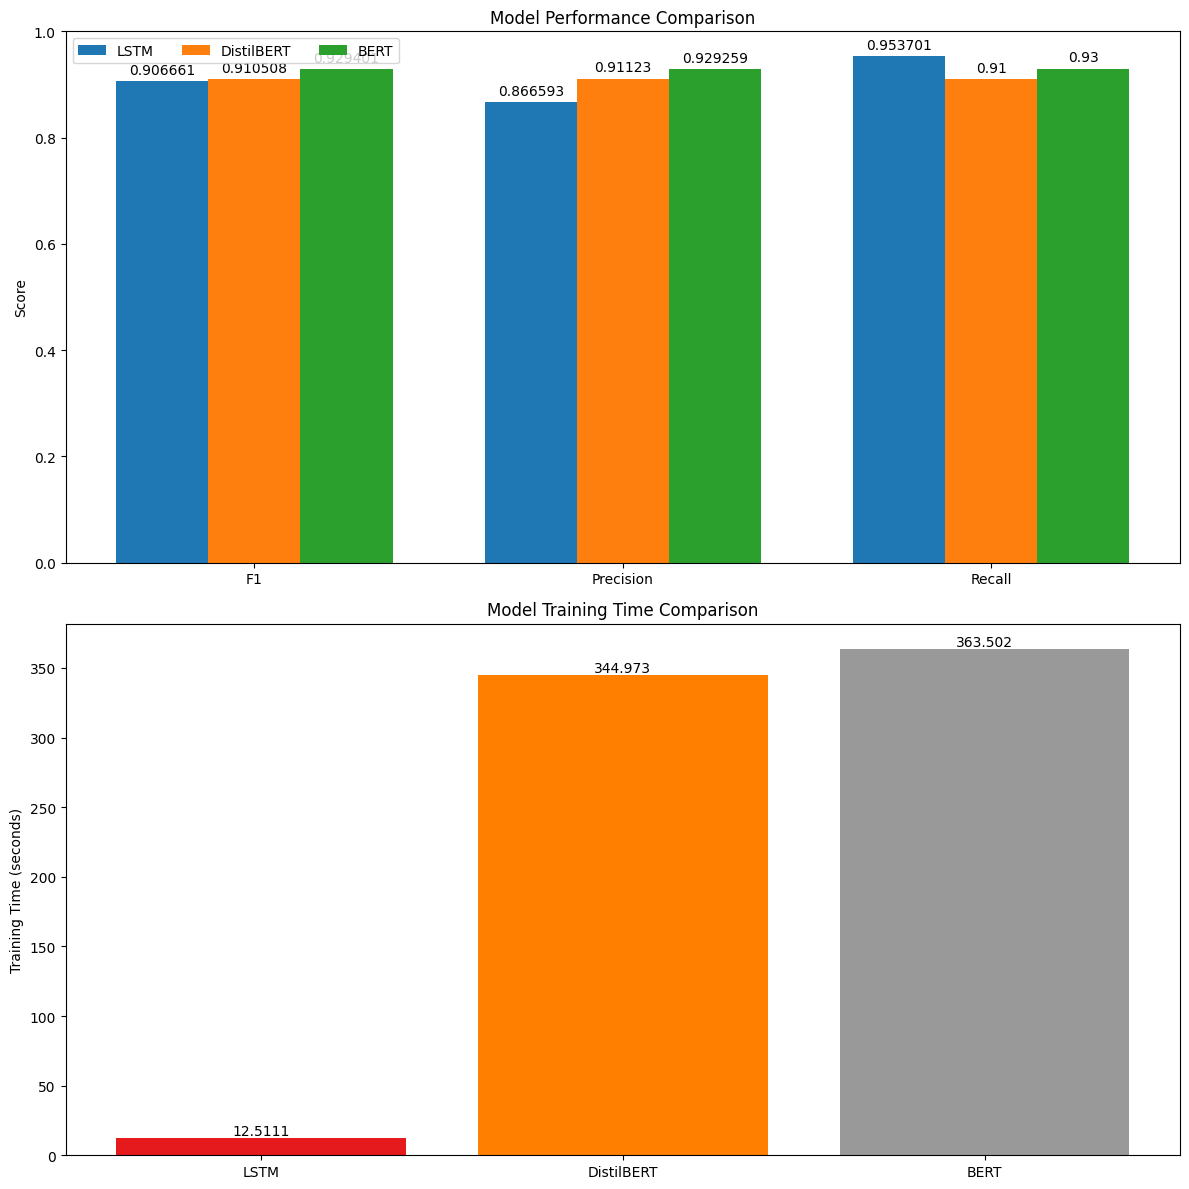

In [ ]:
import matplotlib.pyplot as plt
import time

def plot_model_metrics(model_results, training_times):
    models = list(model_results.keys())
    metrics = ['F1', 'Precision', 'Recall']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Plot F1, Precision, and Recall
    x = np.arange(len(metrics))
    width = 0.25
    multiplier = 0

    for model, results in model_results.items():
        offset = width * multiplier
        rects = ax1.bar(x + offset, [results['f1'], results['precision'], results['recall']],
                        width, label=model)
        ax1.bar_label(rects, padding=3)
        multiplier += 1

    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance Comparison')
    ax1.set_xticks(x + width, metrics)
    ax1.legend(loc='upper left', ncols=3)
    ax1.set_ylim(0, 1)  # Assuming scores are between 0 and 1

    # Plot Training Time
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))
    bars = ax2.bar(models, training_times.values(), color=colors)
    ax2.set_ylabel('Training Time (seconds)')
    ax2.set_title('Model Training Time Comparison')
    ax2.bar_label(bars)

    plt.tight_layout()
    plt.show()


# Plot the results
plot_model_metrics(model_results, training_times)

In [ ]:
def plot_loss_curves(loss_histories):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))

    for i, (model_name, losses) in enumerate(loss_histories.items()):
        ax = axes[i]

        train_losses = losses['train']
        val_losses = losses['val']

        # Use the shorter of the two for the x-axis
        epochs = range(1, min(len(train_losses), len(val_losses)) + 1)

        ax.plot(epochs, train_losses[:len(epochs)], color=colors[i], linestyle='--', label=f'{model_name} Training')
        ax.plot(epochs, val_losses[:len(epochs)], color=colors[i], label=f'{model_name} Validation')

        ax.set_title(f'{model_name} Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss' if i == 0 else '')
        ax.legend()
        ax.grid(True)

    # Set a common y label
    fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical')

    plt.tight_layout()
    plt.show()

<ipython-input-37-dab567dcd817>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))


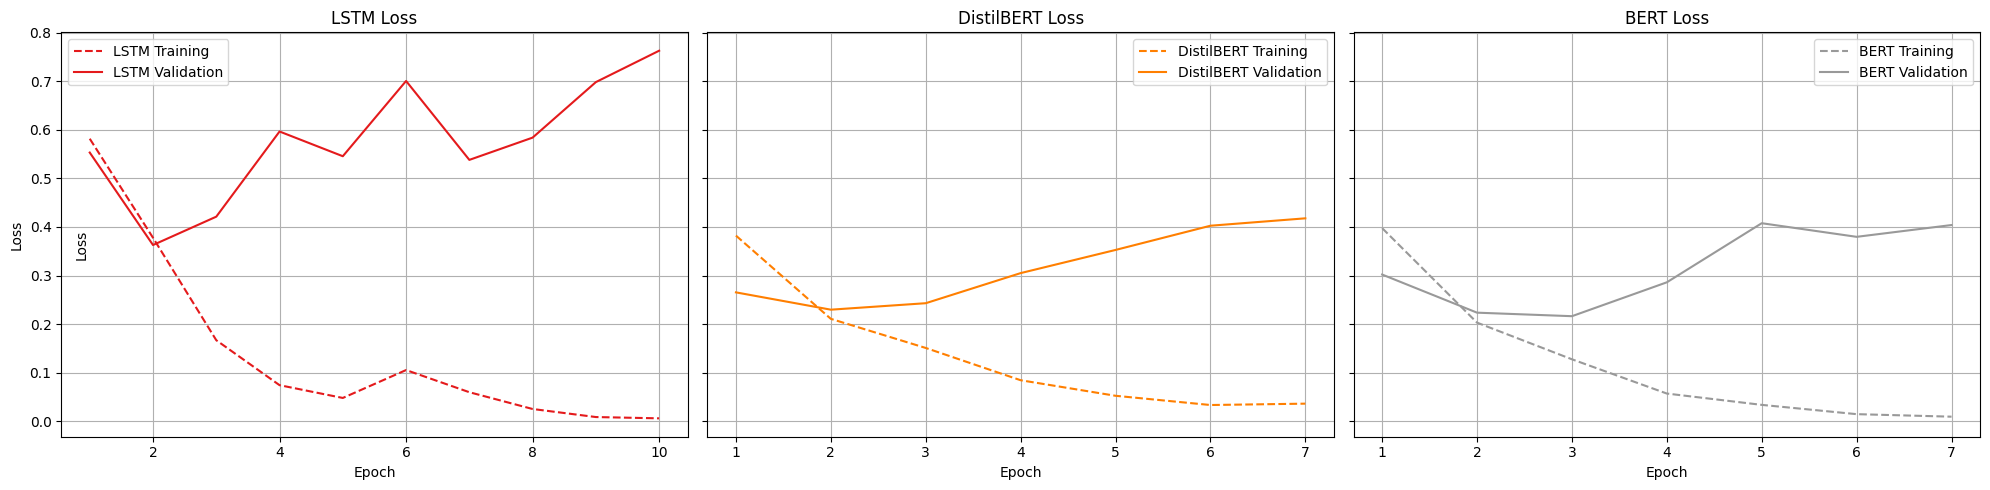

In [ ]:


# Prepare loss histories for plotting
loss_histories = {
    'LSTM': {
        'train': lstm_history.history['loss'],
        'val': lstm_history.history['val_loss']
    },
    'DistilBERT': {
        'train': distillBERT_loss_history.train_losses,
        'val': distillBERT_loss_history.eval_losses
    },
    'BERT': {
        'train': BERT_loss_history.train_losses,
        'val': BERT_loss_history.eval_losses
    }
}

# Plot the loss curves
plot_loss_curves(loss_histories)

## Step 3: Generate Learning Curve with Varying Data Points

We will create different training subsets from the Tripadvisor reviews dataset to evaluate the model's performance on various data sizes. This will allow us to observe how the model's performance improves as the training data size increases.

The subsets will include 100, 500, 1000, 1500, 2000, and 2500 data points.

In [ ]:
import torch
from torch.utils.data import Subset

def subset_custom_dataset(dataset, num_samples):
    indices = torch.randperm(len(dataset))[:num_samples]
    return Subset(dataset, indices)

train_subsets = {
    100: subset_custom_dataset(train_dataset, 100),
    500: subset_custom_dataset(train_dataset, 500),
    1000: subset_custom_dataset(train_dataset, 1000),
    1500: subset_custom_dataset(train_dataset, 1500),
    2000: subset_custom_dataset(train_dataset, 2000),
    2500: subset_custom_dataset(train_dataset, 2500)
}

# Store results for each data subset
performance_results = {}

for data_size, dataset in train_subsets.items():
    print(f"Training with {data_size} data points")

    # Train the model
    trainer, train_result, eval_result, loss_history = train_distilbert_model(
        dataset, valid_dataset, learning_rate=2e-5, num_epochs=10, batch_size=32
    )

    # Save F1, Recall, and Precision
    performance_results[data_size] = eval_result['eval_f1'], eval_result['eval_recall'], eval_result['eval_precision']

# Print performance results
for size, metrics in performance_results.items():
    print(f"Data Size {size}: F1 = {metrics[0]:.4f}, Recall = {metrics[1]:.4f}, Precision = {metrics[2]:.4f}")

Training with 100 data points


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.588690,0.730000,0.616069,0.802900,0.730000
2,No log,0.557852,0.730000,0.616069,0.802900,0.730000
3,No log,0.534208,0.730000,0.616069,0.802900,0.730000
4,No log,0.507907,0.730000,0.616069,0.802900,0.730000
5,No log,0.484418,0.730000,0.616069,0.802900,0.730000
6,No log,0.465167,0.732000,0.620753,0.803968,0.732000
7,No log,0.446807,0.748000,0.662177,0.772589,0.748000
8,No log,0.432461,0.786000,0.736831,0.807953,0.786000
9,No log,0.425400,0.804000,0.773648,0.807620,0.804000
10,No log,0.422592,0.802000,0.771949,0.803454,0.802000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loss: 0.4444714069366455
Evaluation results: {'eval_loss': 0.4254000186920166, 'eval_accuracy': 0.804, 'eval_f1': 0.773647896039604, 'eval_precision': 0.8076202922656528, 'eval_recall': 0.804, 'eval_runtime': 2.226, 'eval_samples_per_second': 224.618, 'eval_steps_per_second': 7.188, 'epoch': 10.0}
Training with 500 data points


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.559444,0.730000,0.616069,0.802900,0.730000
2,No log,0.449511,0.730000,0.616069,0.802900,0.730000
3,No log,0.338214,0.878000,0.876639,0.875970,0.878000
4,No log,0.320892,0.882000,0.876337,0.881216,0.882000
5,No log,0.380944,0.872000,0.859812,0.882291,0.872000
6,No log,0.320789,0.890000,0.885483,0.889070,0.890000
7,0.335500,0.363907,0.856000,0.858937,0.864856,0.856000
8,0.335500,0.355823,0.886000,0.881700,0.884286,0.886000
9,0.335500,0.359981,0.874000,0.873550,0.873174,0.874000
10,0.335500,0.362708,0.878000,0.875982,0.875430,0.878000


Training Loss: 0.23542961180210115
Evaluation results: {'eval_loss': 0.3207889497280121, 'eval_accuracy': 0.89, 'eval_f1': 0.8854831920139515, 'eval_precision': 0.8890695335695814, 'eval_recall': 0.89, 'eval_runtime': 2.413, 'eval_samples_per_second': 207.211, 'eval_steps_per_second': 6.631, 'epoch': 10.0}
Training with 1000 data points


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.409645,0.838000,0.820605,0.841847,0.838000
2,No log,0.277528,0.894000,0.894598,0.895405,0.894000
3,No log,0.301310,0.896000,0.891904,0.895419,0.896000
4,0.334900,0.294605,0.898000,0.898118,0.898245,0.898000
5,0.334900,0.406471,0.870000,0.861819,0.870236,0.870000
6,0.334900,0.363738,0.896000,0.896000,0.896000,0.896000
7,0.094900,0.383246,0.896000,0.895754,0.895542,0.896000
8,0.094900,0.424211,0.886000,0.882433,0.883760,0.886000
9,0.094900,0.414988,0.890000,0.887872,0.887763,0.890000
10,0.047200,0.419045,0.890000,0.887872,0.887763,0.890000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loss: 0.15084987543523312
Evaluation results: {'eval_loss': 0.2946051061153412, 'eval_accuracy': 0.898, 'eval_f1': 0.8981182330341821, 'eval_precision': 0.8982449903038139, 'eval_recall': 0.898, 'eval_runtime': 2.5234, 'eval_samples_per_second': 198.149, 'eval_steps_per_second': 6.341, 'epoch': 10.0}
Training with 1500 data points


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.315944,0.888000,0.882822,0.887637,0.888000
2,No log,0.290230,0.898000,0.892362,0.900814,0.898000
3,0.369100,0.284397,0.888000,0.887735,0.887504,0.888000
4,0.369100,0.298981,0.888000,0.887463,0.887063,0.888000
5,0.168900,0.342722,0.882000,0.880048,0.879575,0.882000
6,0.168900,0.404089,0.884000,0.885026,0.886572,0.884000
7,0.077100,0.380665,0.892000,0.890063,0.889884,0.892000
8,0.077100,0.404686,0.894000,0.892536,0.892147,0.894000
9,0.040500,0.429840,0.888000,0.886897,0.886349,0.888000
10,0.040500,0.438384,0.890000,0.889336,0.888888,0.890000


Training Loss: 0.14353284937270144
Evaluation results: {'eval_loss': 0.40468645095825195, 'eval_accuracy': 0.894, 'eval_f1': 0.8925358093779147, 'eval_precision': 0.892146533973919, 'eval_recall': 0.894, 'eval_runtime': 2.1321, 'eval_samples_per_second': 234.512, 'eval_steps_per_second': 7.504, 'epoch': 10.0}
Training with 2000 data points


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.291566,0.886000,0.887804,0.891400,0.886000
2,0.404200,0.267912,0.876000,0.879353,0.888635,0.876000
3,0.404200,0.268394,0.902000,0.898934,0.900929,0.902000
4,0.206500,0.296062,0.900000,0.897027,0.898642,0.900000
5,0.097000,0.393921,0.892000,0.890653,0.890187,0.892000
6,0.097000,0.438846,0.892000,0.892000,0.892000,0.892000
7,0.049100,0.463005,0.892000,0.891213,0.890738,0.892000
8,0.022600,0.467421,0.898000,0.897127,0.896685,0.898000
9,0.022600,0.495245,0.890000,0.889871,0.889750,0.890000
10,0.012100,0.493855,0.894000,0.893621,0.893320,0.894000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loss: 0.12695178872063045
Evaluation results: {'eval_loss': 0.2683940529823303, 'eval_accuracy': 0.902, 'eval_f1': 0.8989339269104418, 'eval_precision': 0.9009287555228277, 'eval_recall': 0.902, 'eval_runtime': 2.438, 'eval_samples_per_second': 205.086, 'eval_steps_per_second': 6.563, 'epoch': 10.0}
Training with 2500 data points


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.305326,0.880000,0.870210,0.887371,0.880000
2,0.382800,0.251995,0.898000,0.899614,0.903057,0.898000
3,0.212200,0.287351,0.900000,0.901677,0.905435,0.900000
4,0.128100,0.320300,0.898000,0.897636,0.897349,0.898000
5,0.128100,0.394473,0.890000,0.886209,0.888310,0.890000
6,0.079300,0.393920,0.890000,0.890621,0.891448,0.890000
7,0.055300,0.445606,0.888000,0.888753,0.889803,0.888000
8,0.029500,0.469200,0.894000,0.895264,0.897517,0.894000
9,0.034100,0.455977,0.898000,0.897636,0.897349,0.898000
10,0.034100,0.462366,0.900000,0.899521,0.899181,0.900000


Training Loss: 0.11857174227509318
Evaluation results: {'eval_loss': 0.28735050559043884, 'eval_accuracy': 0.9, 'eval_f1': 0.9016767546179312, 'eval_precision': 0.9054346382284294, 'eval_recall': 0.9, 'eval_runtime': 2.1445, 'eval_samples_per_second': 233.159, 'eval_steps_per_second': 7.461, 'epoch': 10.0}
Data Size 100: F1 = 0.7736, Recall = 0.8040, Precision = 0.8076
Data Size 500: F1 = 0.8855, Recall = 0.8900, Precision = 0.8891
Data Size 1000: F1 = 0.8981, Recall = 0.8980, Precision = 0.8982
Data Size 1500: F1 = 0.8925, Recall = 0.8940, Precision = 0.8921
Data Size 2000: F1 = 0.8989, Recall = 0.9020, Precision = 0.9009
Data Size 2500: F1 = 0.9017, Recall = 0.9000, Precision = 0.9054


Now that we have trained the model on different data sizes, we can plot the learning curves to observe how the F1, Recall, and Precision metrics improve as we increase the training dataset size.

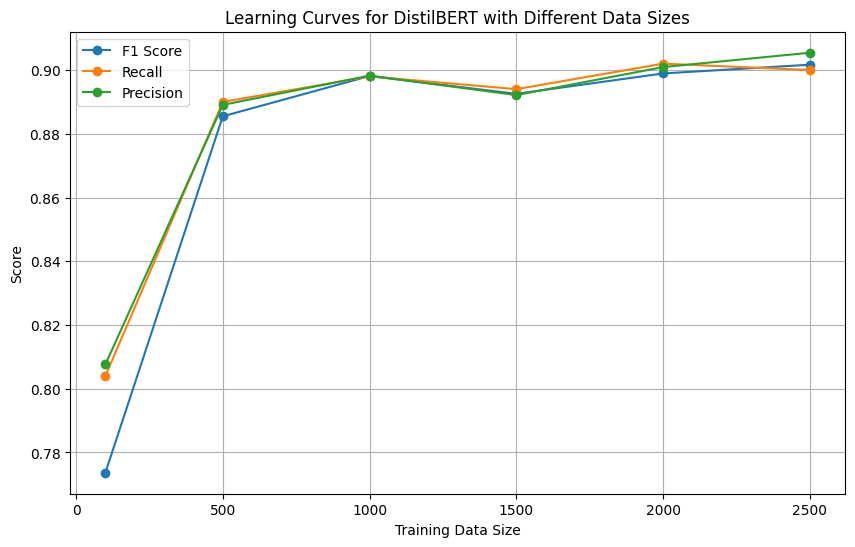

In [ ]:
# Extract the data for plotting
data_sizes = list(performance_results.keys())
f1_scores = [performance_results[size][0] for size in data_sizes]
recall_scores = [performance_results[size][1] for size in data_sizes]
precision_scores = [performance_results[size][2] for size in data_sizes]

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, f1_scores, label="F1 Score", marker='o')
plt.plot(data_sizes, recall_scores, label="Recall", marker='o')
plt.plot(data_sizes, precision_scores, label="Precision", marker='o')

plt.title("Learning Curves for DistilBERT with Different Data Sizes")
plt.xlabel("Training Data Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

## Step 4: Explore Hyperparameters

Next, we will explore the impact of varying learning rates, epochs, batch sizes, and dropout rates on the performance of the DistilBERT model. For each hyperparameter, we will adjust its value while keeping the other parameters constant.

We will run experiments for:

    Learning Rates: 2e-8, 2e-5, 2e-2
    Epochs: 1, 5, 10
    Batch Sizes: 2, 32, 128
    Dropout Rates: 0, 0.1, 0.3, 0.5

**Varying Learning Rates**

In [ ]:
import matplotlib.pyplot as plt

learning_rates = [2e-8, 2e-5, 2e-2]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    trainer, train_result, eval_result, loss_history = train_distilbert_model(
        train_dataset, valid_dataset, learning_rate=lr, num_epochs=10, batch_size=32
    )
    print(f"Results for learning rate {lr}: F1 = {eval_result['eval_f1']:.4f}, Recall = {eval_result['eval_recall']:.4f}, Precision = {eval_result['eval_precision']:.4f}")

    results[lr] = {
        'train_loss': loss_history.train_losses,
        'val_loss': loss_history.eval_losses,
        'metrics': eval_result
    }

Training with learning rate: 2e-08


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.735286,0.270000,0.114803,0.802900,0.270000
2,0.738300,0.731773,0.270000,0.114803,0.802900,0.270000
3,0.731700,0.728741,0.270000,0.114803,0.802900,0.270000
4,0.729100,0.726132,0.270000,0.114803,0.802900,0.270000
5,0.729100,0.723918,0.270000,0.114803,0.802900,0.270000
6,0.725200,0.722201,0.270000,0.114803,0.802900,0.270000
7,0.724600,0.720808,0.270000,0.114803,0.802900,0.270000
8,0.721700,0.719850,0.270000,0.114803,0.802900,0.270000
9,0.720400,0.719277,0.270000,0.114803,0.802900,0.270000
10,0.720400,0.719146,0.270000,0.114803,0.802900,0.270000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loss: 0.726257478738133
Evaluation results: {'eval_loss': 0.7352861166000366, 'eval_accuracy': 0.27, 'eval_f1': 0.11480314960629921, 'eval_precision': 0.8029, 'eval_recall': 0.27, 'eval_runtime': 3.0304, 'eval_samples_per_second': 164.997, 'eval_steps_per_second': 5.28, 'epoch': 10.0}
Results for learning rate 2e-08: F1 = 0.1148, Recall = 0.2700, Precision = 0.8029
Training with learning rate: 2e-05


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.264825,0.902000,0.897976,0.902269,0.902000
2,0.398700,0.232087,0.898000,0.896862,0.896444,0.898000
3,0.210100,0.255244,0.904000,0.905240,0.907674,0.904000
4,0.153800,0.313490,0.906000,0.903634,0.904679,0.906000
5,0.153800,0.330214,0.892000,0.892491,0.893115,0.892000
6,0.085200,0.379316,0.894000,0.893361,0.892938,0.894000
7,0.054700,0.455059,0.878000,0.879696,0.882727,0.878000
8,0.035700,0.400460,0.900000,0.897632,0.898273,0.900000
9,0.034800,0.437778,0.890000,0.890377,0.890830,0.890000
10,0.034800,0.453555,0.886000,0.887127,0.888912,0.886000


Training Loss: 0.12568260084224653
Evaluation results: {'eval_loss': 0.25524386763572693, 'eval_accuracy': 0.904, 'eval_f1': 0.9052403247792331, 'eval_precision': 0.9076741631496792, 'eval_recall': 0.904, 'eval_runtime': 2.2851, 'eval_samples_per_second': 218.808, 'eval_steps_per_second': 7.002, 'epoch': 10.0}
Results for learning rate 2e-05: F1 = 0.9052, Recall = 0.9040, Precision = 0.9077
Training with learning rate: 0.02


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.587883,0.730000,0.616069,0.802900,0.730000
2,3.889100,0.634102,0.730000,0.616069,0.802900,0.730000
3,0.608000,0.583503,0.730000,0.616069,0.802900,0.730000
4,0.573700,0.583220,0.730000,0.616069,0.802900,0.730000
5,0.573700,0.583193,0.730000,0.616069,0.802900,0.730000
6,0.587600,0.583679,0.730000,0.616069,0.802900,0.730000
7,0.572700,0.583228,0.730000,0.616069,0.802900,0.730000
8,0.579400,0.583298,0.730000,0.616069,0.802900,0.730000
9,0.581500,0.583162,0.730000,0.616069,0.802900,0.730000
10,0.581500,0.583369,0.730000,0.616069,0.802900,0.730000


Training Loss: 1.0022113220601143
Evaluation results: {'eval_loss': 0.5878832936286926, 'eval_accuracy': 0.73, 'eval_f1': 0.6160693641618498, 'eval_precision': 0.8029, 'eval_recall': 0.73, 'eval_runtime': 2.1235, 'eval_samples_per_second': 235.461, 'eval_steps_per_second': 7.535, 'epoch': 10.0}
Results for learning rate 0.02: F1 = 0.6161, Recall = 0.7300, Precision = 0.8029


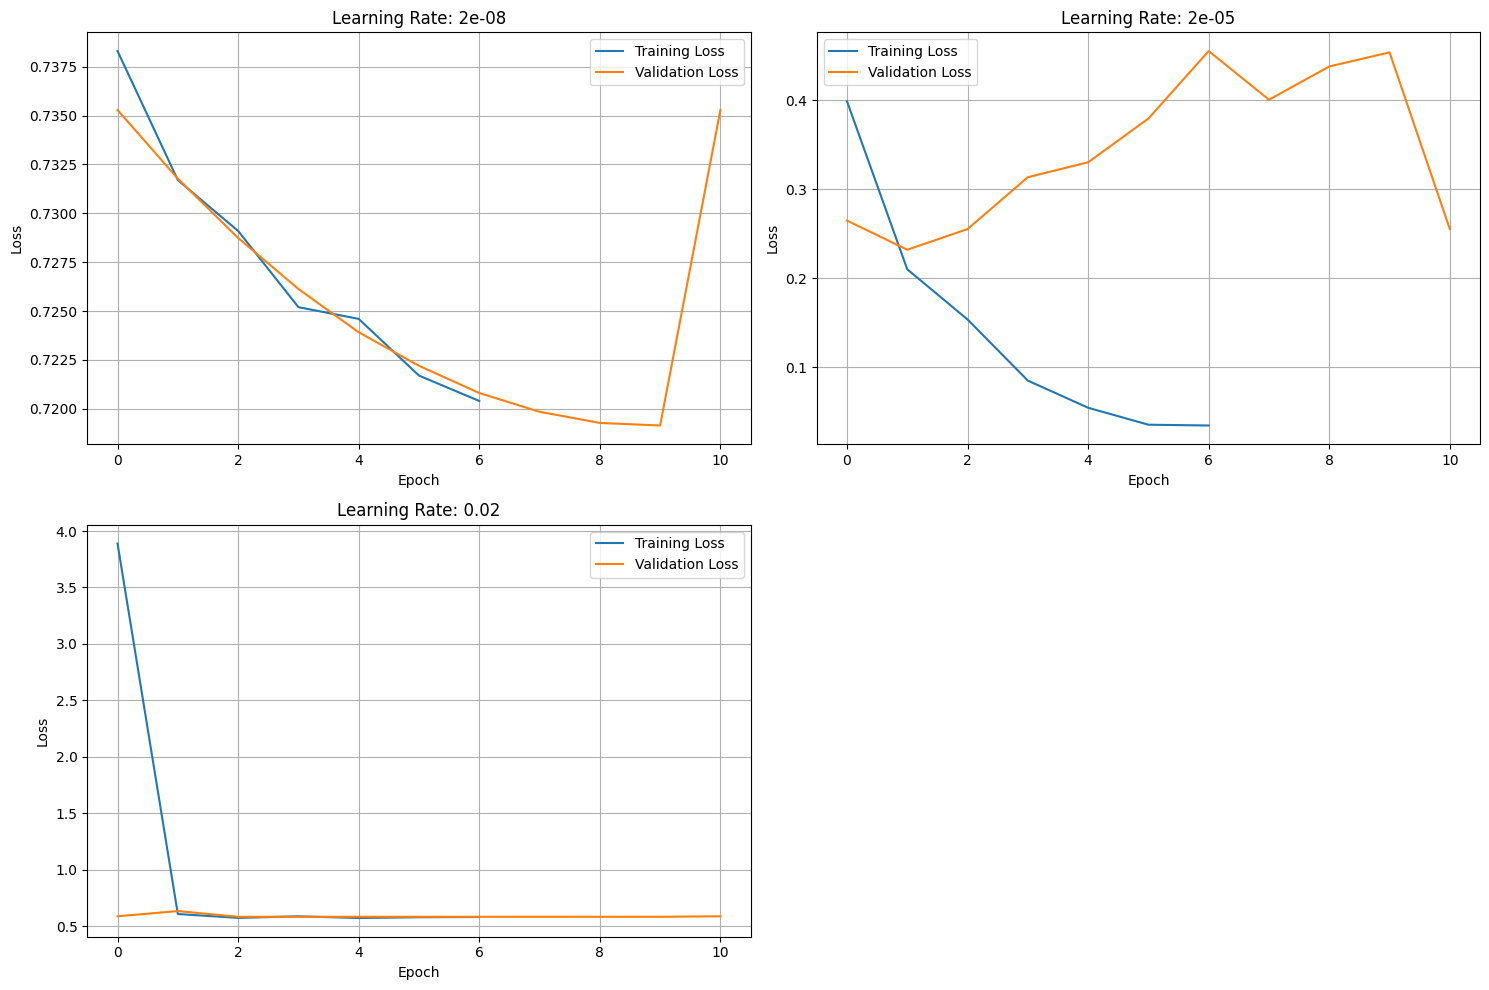


Summary of Results:

Learning Rate: 2e-08
Final Training Loss: 0.7204
Final Validation Loss: 0.7353
F1 Score: 0.1148
Recall: 0.2700
Precision: 0.8029

Learning Rate: 2e-05
Final Training Loss: 0.0348
Final Validation Loss: 0.2552
F1 Score: 0.9052
Recall: 0.9040
Precision: 0.9077

Learning Rate: 0.02
Final Training Loss: 0.5815
Final Validation Loss: 0.5879
F1 Score: 0.6161
Recall: 0.7300
Precision: 0.8029


In [ ]:
# Plotting the loss curves
plt.figure(figsize=(15, 10))

for i, (lr, data) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(data['train_loss'], label='Training Loss')
    plt.plot(data['val_loss'], label='Validation Loss')
    plt.title(f'Learning Rate: {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print a summary of the results
print("\nSummary of Results:")
for lr, data in results.items():
    print(f"\nLearning Rate: {lr}")
    print(f"Final Training Loss: {data['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {data['val_loss'][-1]:.4f}")
    print(f"F1 Score: {data['metrics']['eval_f1']:.4f}")
    print(f"Recall: {data['metrics']['eval_recall']:.4f}")
    print(f"Precision: {data['metrics']['eval_precision']:.4f}")

**Varying Epoch Size**

In [ ]:
import matplotlib.pyplot as plt

epochs = [5, 10, 15]
results = {}

for epoch in epochs:
    print(f"Training with {epoch} epochs")
    trainer, train_result, eval_result, loss_history = train_distilbert_model(
        train_dataset, valid_dataset, learning_rate=2e-5, num_epochs=epoch, batch_size=32
    )
    print(f"Results for {epoch} epochs: F1 = {eval_result['eval_f1']:.4f}, Recall = {eval_result['eval_recall']:.4f}, Precision = {eval_result['eval_precision']:.4f}")

    results[epoch] = {
        'train_loss': loss_history.train_losses,
        'val_loss': loss_history.eval_losses,
        'metrics': eval_result
    }


Training with 5 epochs


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.264709,0.896000,0.891904,0.895419,0.896000
2,0.398100,0.242484,0.902000,0.899823,0.900327,0.902000
3,0.213800,0.250020,0.906000,0.906323,0.906722,0.906000
4,0.162100,0.290831,0.900000,0.899271,0.898859,0.900000
5,0.162100,0.308407,0.894000,0.893621,0.893320,0.894000


Training Loss: 0.22045678005942815
Evaluation results: {'eval_loss': 0.25002020597457886, 'eval_accuracy': 0.906, 'eval_f1': 0.9063225357860846, 'eval_precision': 0.9067223156377613, 'eval_recall': 0.906, 'eval_runtime': 2.3016, 'eval_samples_per_second': 217.242, 'eval_steps_per_second': 6.952, 'epoch': 5.0}
Results for 5 epochs: F1 = 0.9063, Recall = 0.9060, Precision = 0.9067
Training with 10 epochs


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.311391,0.882000,0.872113,0.890628,0.882000
2,0.389700,0.226976,0.910000,0.910309,0.910695,0.910000
3,0.209700,0.245613,0.900000,0.899521,0.899181,0.900000
4,0.145600,0.350678,0.898000,0.896862,0.896444,0.898000
5,0.145600,0.388464,0.890000,0.890377,0.890830,0.890000
6,0.080300,0.449905,0.886000,0.885024,0.884470,0.886000
7,0.051000,0.476235,0.888000,0.887463,0.887063,0.888000
8,0.027600,0.543703,0.878000,0.873795,0.875331,0.878000
9,0.024900,0.529855,0.882000,0.880990,0.880398,0.882000
10,0.024900,0.533316,0.880000,0.879716,0.879466,0.880000


Training Loss: 0.11907415390014649
Evaluation results: {'eval_loss': 0.22697629034519196, 'eval_accuracy': 0.91, 'eval_f1': 0.9103088108590172, 'eval_precision': 0.910695411962527, 'eval_recall': 0.91, 'eval_runtime': 2.1092, 'eval_samples_per_second': 237.059, 'eval_steps_per_second': 7.586, 'epoch': 10.0}
Results for 10 epochs: F1 = 0.9103, Recall = 0.9100, Precision = 0.9107
Training with 15 epochs


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.266536,0.900000,0.895724,0.900362,0.900000
2,0.400000,0.231288,0.900000,0.899015,0.898598,0.900000
3,0.209500,0.250039,0.898000,0.899009,0.900688,0.898000
4,0.144500,0.337407,0.900000,0.896062,0.899800,0.900000
5,0.144500,0.345309,0.892000,0.892249,0.892531,0.892000
6,0.081500,0.409566,0.902000,0.901161,0.900757,0.902000
7,0.053200,0.422515,0.898000,0.897385,0.896988,0.898000
8,0.027600,0.458286,0.888000,0.885991,0.885726,0.888000
9,0.024600,0.511653,0.882000,0.883641,0.886625,0.882000
10,0.024600,0.528364,0.888000,0.888000,0.888000,0.888000


Training Loss: 0.08255017538110918
Evaluation results: {'eval_loss': 0.40956634283065796, 'eval_accuracy': 0.902, 'eval_f1': 0.9011612177618646, 'eval_precision': 0.9007568884408602, 'eval_recall': 0.902, 'eval_runtime': 2.0825, 'eval_samples_per_second': 240.091, 'eval_steps_per_second': 7.683, 'epoch': 15.0}
Results for 15 epochs: F1 = 0.9012, Recall = 0.9020, Precision = 0.9008


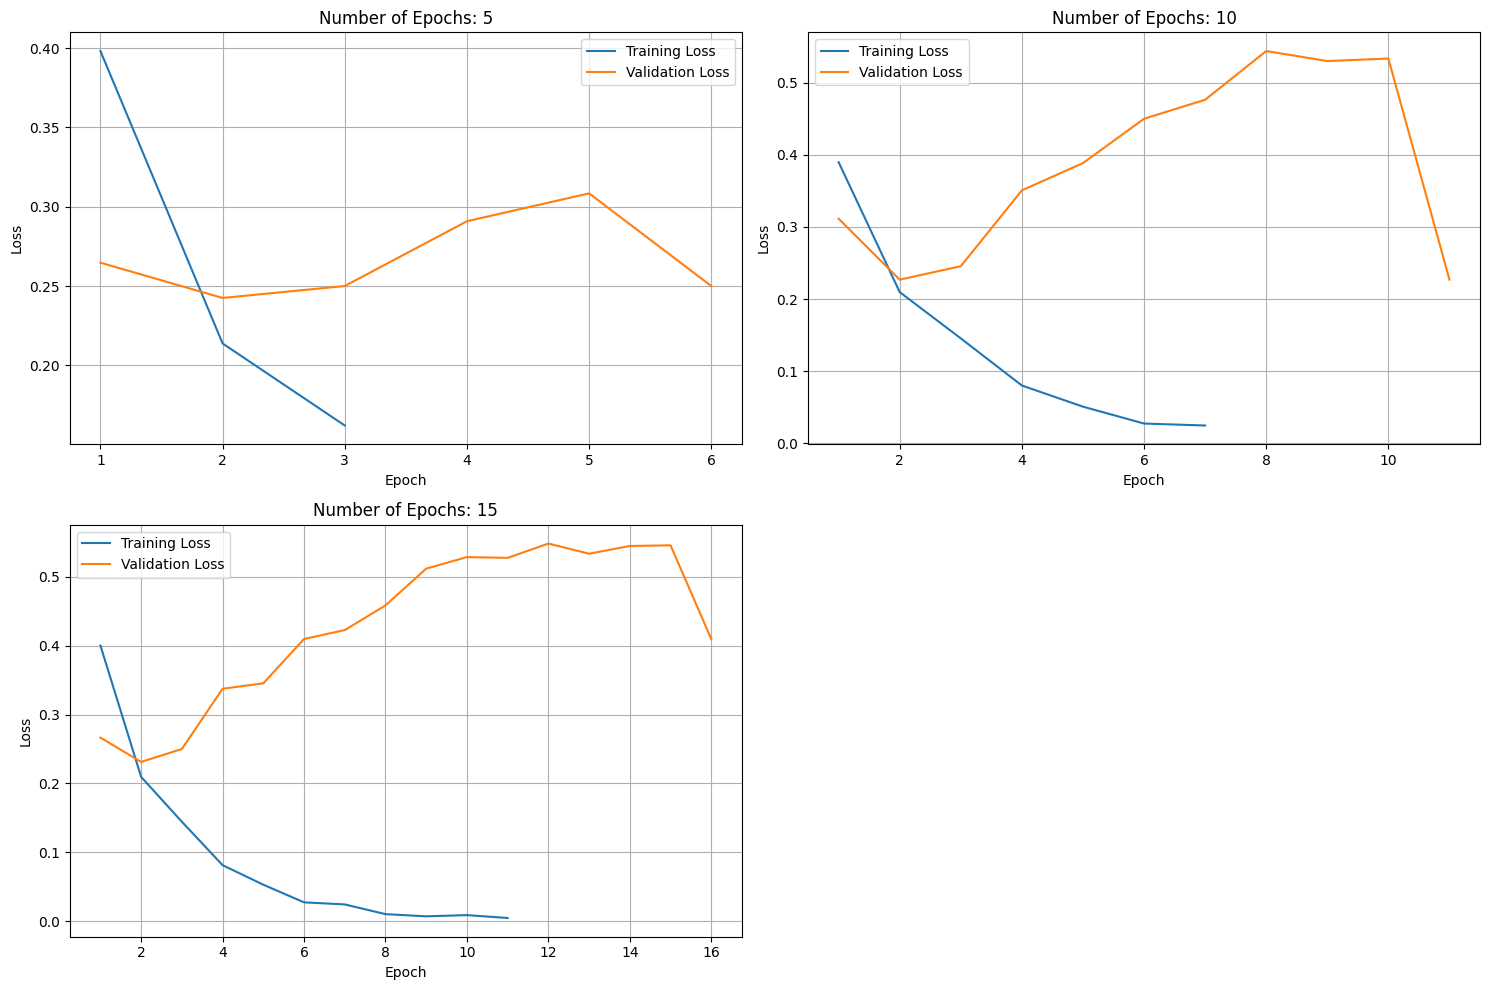


Summary of Results:

Number of Epochs: 5
Final Training Loss: 0.1621
Final Validation Loss: 0.2500
F1 Score: 0.9063
Recall: 0.9060
Precision: 0.9067

Number of Epochs: 10
Final Training Loss: 0.0249
Final Validation Loss: 0.2270
F1 Score: 0.9103
Recall: 0.9100
Precision: 0.9107

Number of Epochs: 15
Final Training Loss: 0.0049
Final Validation Loss: 0.4096
F1 Score: 0.9012
Recall: 0.9020
Precision: 0.9008


In [ ]:
plt.figure(figsize=(15, 10))

for i, (epoch, data) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(range(1, len(data['train_loss'])+1), data['train_loss'], label='Training Loss')
    plt.plot(range(1, len(data['val_loss'])+1), data['val_loss'], label='Validation Loss')
    plt.title(f'Number of Epochs: {epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print a summary of the results
print("\nSummary of Results:")
for epoch, data in results.items():
    print(f"\nNumber of Epochs: {epoch}")
    print(f"Final Training Loss: {data['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {data['val_loss'][-1]:.4f}")
    print(f"F1 Score: {data['metrics']['eval_f1']:.4f}")
    print(f"Recall: {data['metrics']['eval_recall']:.4f}")
    print(f"Precision: {data['metrics']['eval_precision']:.4f}")

**Varying Batch Size**

In [ ]:
import matplotlib.pyplot as plt

batch_sizes = [16, 64, 128]
results = {}

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    trainer, train_result, eval_result, loss_history = train_distilbert_model(
        train_dataset, valid_dataset, learning_rate=2e-5, num_epochs=10, batch_size=batch_size
    )
    print(f"Results for batch size {batch_size}: F1 = {eval_result['eval_f1']:.4f}, Recall = {eval_result['eval_recall']:.4f}, Precision = {eval_result['eval_precision']:.4f}")

    results[batch_size] = {
        'train_loss': loss_history.train_losses,
        'val_loss': loss_history.eval_losses,
        'metrics': eval_result
    }

Training with batch size: 16


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.405500,0.244410,0.904000,0.900536,0.903673,0.904000
2,0.202300,0.292698,0.884000,0.885725,0.889010,0.884000
3,0.158000,0.390461,0.882000,0.874574,0.884247,0.882000
4,0.109100,0.462932,0.890000,0.887232,0.887765,0.890000
5,0.063500,0.459302,0.894000,0.895678,0.899171,0.894000
6,0.038500,0.532178,0.888000,0.884319,0.886017,0.888000
7,0.032300,0.519821,0.894000,0.893361,0.892938,0.894000
8,0.017600,0.543743,0.896000,0.895501,0.895141,0.896000
9,0.010000,0.555530,0.894000,0.894598,0.895405,0.894000
10,0.014100,0.530765,0.896000,0.895501,0.895141,0.896000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loss: 0.10168902228592308
Evaluation results: {'eval_loss': 0.2444104552268982, 'eval_accuracy': 0.904, 'eval_f1': 0.900536039552433, 'eval_precision': 0.9036730096905137, 'eval_recall': 0.904, 'eval_runtime': 2.2916, 'eval_samples_per_second': 218.19, 'eval_steps_per_second': 13.964, 'epoch': 10.0}
Results for batch size 16: F1 = 0.9005, Recall = 0.9040, Precision = 0.9037
Training with batch size: 64


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.324476,0.876000,0.873424,0.873091,0.876000
2,No log,0.259729,0.894000,0.891012,0.892131,0.894000
3,0.345000,0.268536,0.892000,0.889442,0.889845,0.892000
4,0.345000,0.291568,0.884000,0.884000,0.884000,0.884000
5,0.139200,0.333929,0.888000,0.887184,0.886677,0.888000
6,0.139200,0.386761,0.886000,0.886643,0.887492,0.886000
7,0.139200,0.366400,0.884000,0.882858,0.882266,0.884000
8,0.070200,0.413737,0.880000,0.879425,0.878984,0.880000
9,0.070200,0.421100,0.880000,0.879425,0.878984,0.880000
10,0.051900,0.429323,0.878000,0.878141,0.878291,0.878000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loss: 0.1515507221221924
Evaluation results: {'eval_loss': 0.25972917675971985, 'eval_accuracy': 0.894, 'eval_f1': 0.8910121444499703, 'eval_precision': 0.892131169893646, 'eval_recall': 0.894, 'eval_runtime': 2.4049, 'eval_samples_per_second': 207.912, 'eval_steps_per_second': 3.327, 'epoch': 10.0}
Results for batch size 64: F1 = 0.8910, Recall = 0.8940, Precision = 0.8921
Training with batch size: 128


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.487224,0.730000,0.616069,0.802900,0.730000
2,No log,0.299340,0.886000,0.882071,0.883984,0.886000
3,No log,0.263989,0.900000,0.902040,0.907293,0.900000
4,No log,0.249637,0.898000,0.898118,0.898245,0.898000
5,0.317100,0.267287,0.892000,0.891482,0.891102,0.892000
6,0.317100,0.276483,0.894000,0.893093,0.892613,0.894000
7,0.317100,0.301224,0.896000,0.893537,0.894059,0.896000
8,0.317100,0.319522,0.882000,0.883641,0.886625,0.882000
9,0.317100,0.330679,0.882000,0.883167,0.884986,0.882000
10,0.104300,0.328777,0.876000,0.875707,0.875447,0.876000


Training Loss: 0.21071317195892333
Evaluation results: {'eval_loss': 0.2639889419078827, 'eval_accuracy': 0.9, 'eval_f1': 0.9020398251578435, 'eval_precision': 0.9072931276297335, 'eval_recall': 0.9, 'eval_runtime': 2.1239, 'eval_samples_per_second': 235.414, 'eval_steps_per_second': 1.883, 'epoch': 10.0}
Results for batch size 128: F1 = 0.9020, Recall = 0.9000, Precision = 0.9073


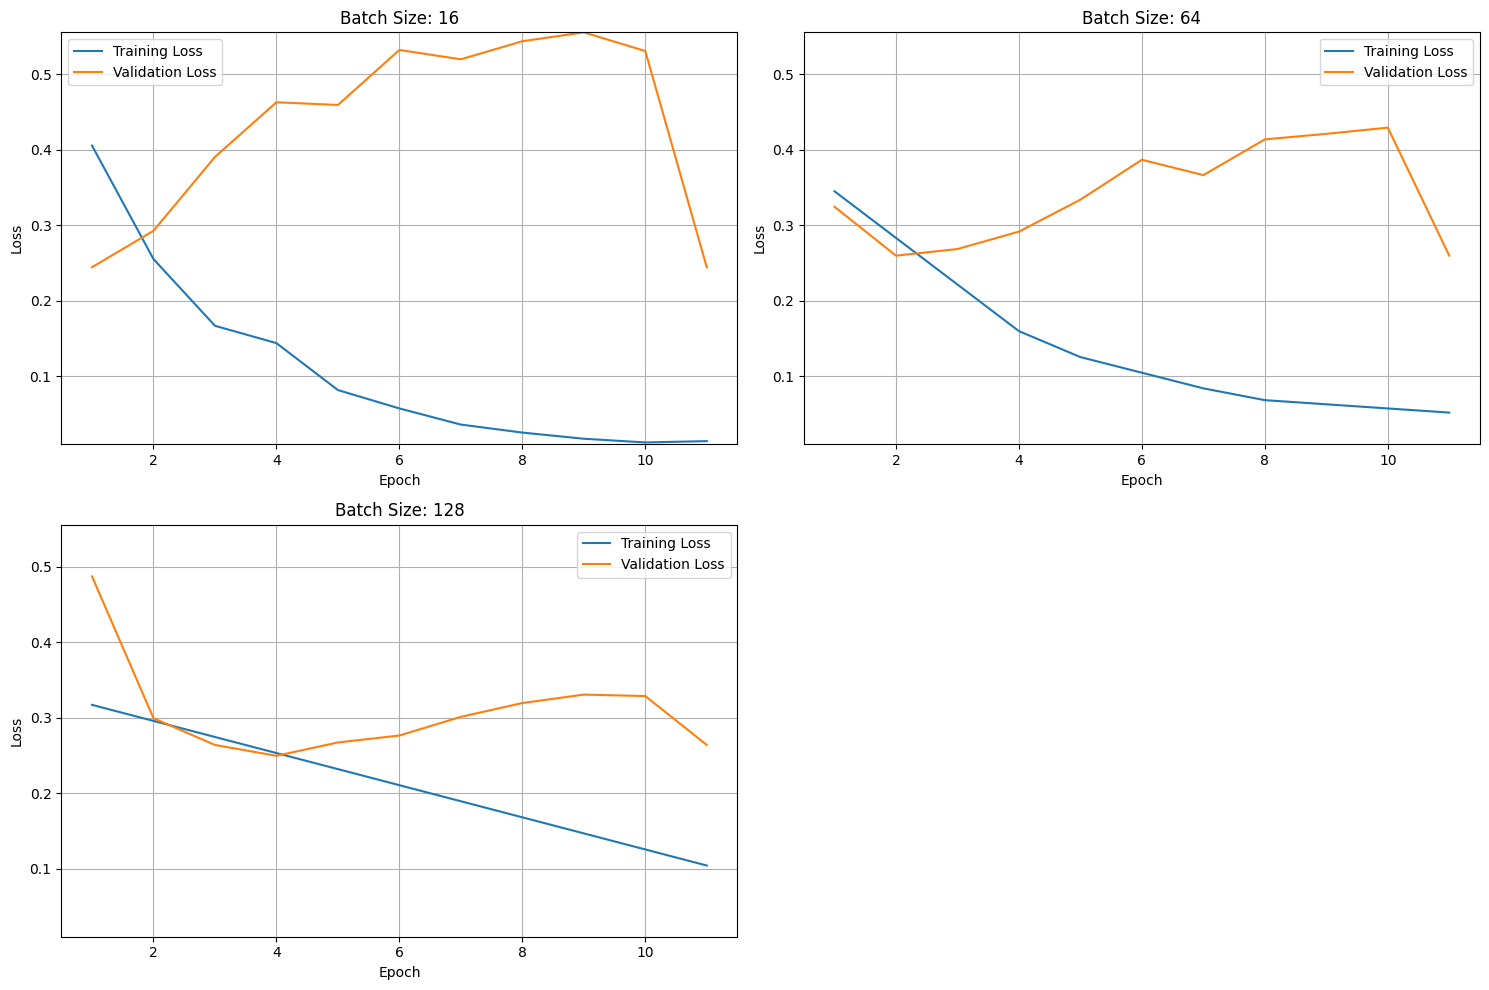


Summary of Results:

Batch Size: 16
Final Training Loss: 0.0141
Final Validation Loss: 0.2444
F1 Score: 0.9005
Recall: 0.9040
Precision: 0.9037

Batch Size: 64
Final Training Loss: 0.0519
Final Validation Loss: 0.2597
F1 Score: 0.8910
Recall: 0.8940
Precision: 0.8921

Batch Size: 128
Final Training Loss: 0.1043
Final Validation Loss: 0.2640
F1 Score: 0.9020
Recall: 0.9000
Precision: 0.9073


In [ ]:
plt.figure(figsize=(15, 10))

# Find the minimum number of epochs across all batch sizes
min_epochs = min(len(data['val_loss']) for data in results.values())

for i, (batch_size, data) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)

    # Interpolate training loss to match the number of validation loss points
    train_loss = np.interp(np.linspace(0, len(data['train_loss'])-1, min_epochs),
                           np.arange(len(data['train_loss'])),
                           data['train_loss'])

    # Use only the first min_epochs points for validation loss
    val_loss = data['val_loss'][:min_epochs]

    epochs = range(1, min_epochs+1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Batch Size: {batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Set the same y-axis limits for all subplots
y_min = min(min(data['train_loss'] + data['val_loss'][:min_epochs]) for data in results.values())
y_max = max(max(data['train_loss'] + data['val_loss'][:min_epochs]) for data in results.values())
for ax in plt.gcf().get_axes():
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print a summary of the results
print("\nSummary of Results:")
for batch_size, data in results.items():
    print(f"\nBatch Size: {batch_size}")
    print(f"Final Training Loss: {data['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {data['val_loss'][-1]:.4f}")
    print(f"F1 Score: {data['metrics']['eval_f1']:.4f}")
    print(f"Recall: {data['metrics']['eval_recall']:.4f}")
    print(f"Precision: {data['metrics']['eval_precision']:.4f}")

**Drop Out Variation**

In this step, we will vary the dropout rates to observe how it affects the model’s performance. We will try dropout rates of 0.1, 0.3, and 0.5, and then evaluate the impact on F1, Recall, and Precision.

In [ ]:
dropout_rates = [0, 0.25, 0.5, 0.75]
results = {}

for dropout in dropout_rates:
    print(f"Training with dropout rate: {dropout}")
    trainer, train_result, eval_result, loss_history = train_distilbert_model(
        train_dataset, valid_dataset, learning_rate=2e-5, num_epochs=10, batch_size=32, dropout_rate=dropout
    )
    print(f"Results for dropout {dropout}: F1 = {eval_result['eval_f1']:.4f}, Recall = {eval_result['eval_recall']:.4f}, Precision = {eval_result['eval_precision']:.4f}")

    results[dropout] = {
        'train_loss': loss_history.train_losses,
        'val_loss': loss_history.eval_losses,
        'metrics': eval_result
    }


Training with dropout rate: 0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.269971,0.894000,0.889285,0.894018,0.894000
2,0.383400,0.224118,0.910000,0.909230,0.908900,0.910000
3,0.199300,0.261680,0.900000,0.901091,0.903011,0.900000
4,0.150200,0.346306,0.896000,0.897135,0.899093,0.896000
5,0.150200,0.401028,0.888000,0.890851,0.898941,0.888000
6,0.068600,0.401643,0.894000,0.895048,0.896763,0.894000
7,0.042000,0.406881,0.894000,0.894364,0.894803,0.894000
8,0.018000,0.422550,0.900000,0.900230,0.900495,0.900000
9,0.014100,0.437545,0.892000,0.892000,0.892000,0.892000
10,0.014100,0.443415,0.898000,0.898350,0.898776,0.898000


Training Loss: 0.11187118337124209
Evaluation results: {'eval_loss': 0.22411812841892242, 'eval_accuracy': 0.91, 'eval_f1': 0.9092296897813044, 'eval_precision': 0.908900369623656, 'eval_recall': 0.91, 'eval_runtime': 2.0658, 'eval_samples_per_second': 242.039, 'eval_steps_per_second': 7.745, 'epoch': 10.0}
Results for dropout 0: F1 = 0.9092, Recall = 0.9100, Precision = 0.9089
Training with dropout rate: 0.25


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.284520,0.890000,0.884325,0.890875,0.890000
2,0.414600,0.224276,0.912000,0.911359,0.911041,0.912000
3,0.224800,0.240602,0.898000,0.898795,0.899999,0.898000
4,0.179200,0.299387,0.900000,0.897923,0.898200,0.900000
5,0.179200,0.330208,0.894000,0.895264,0.897517,0.894000
6,0.108800,0.366022,0.894000,0.893093,0.892613,0.894000
7,0.072600,0.388549,0.894000,0.894123,0.894254,0.894000
8,0.051700,0.397805,0.894000,0.892818,0.892349,0.894000
9,0.046100,0.442001,0.894000,0.894598,0.895405,0.894000
10,0.046100,0.428506,0.894000,0.894123,0.894254,0.894000


Training Loss: 0.14330471407009077
Evaluation results: {'eval_loss': 0.22427551448345184, 'eval_accuracy': 0.912, 'eval_f1': 0.9113586956521739, 'eval_precision': 0.911041183476462, 'eval_recall': 0.912, 'eval_runtime': 2.1345, 'eval_samples_per_second': 234.251, 'eval_steps_per_second': 7.496, 'epoch': 10.0}
Results for dropout 0.25: F1 = 0.9114, Recall = 0.9120, Precision = 0.9110
Training with dropout rate: 0.5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.341291,0.864000,0.848355,0.880087,0.864000
2,0.432300,0.277113,0.896000,0.890056,0.899002,0.896000
3,0.253200,0.251551,0.904000,0.900845,0.903253,0.904000
4,0.201900,0.299042,0.898000,0.892738,0.899925,0.898000
5,0.201900,0.253432,0.900000,0.900230,0.900495,0.900000
6,0.170600,0.296846,0.896000,0.896473,0.897080,0.896000
7,0.129300,0.330069,0.902000,0.900104,0.900276,0.902000
8,0.108300,0.341474,0.898000,0.897385,0.896988,0.898000
9,0.100000,0.356941,0.894000,0.893621,0.893320,0.894000
10,0.100000,0.357874,0.894000,0.893093,0.892613,0.894000


Training Loss: 0.18608829944948607
Evaluation results: {'eval_loss': 0.25155073404312134, 'eval_accuracy': 0.904, 'eval_f1': 0.9008449246296177, 'eval_precision': 0.9032529701938442, 'eval_recall': 0.904, 'eval_runtime': 2.1868, 'eval_samples_per_second': 228.643, 'eval_steps_per_second': 7.317, 'epoch': 10.0}
Results for dropout 0.5: F1 = 0.9008, Recall = 0.9040, Precision = 0.9033
Training with dropout rate: 0.75


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.405251,0.824000,0.790918,0.858190,0.824000
2,0.492700,0.329446,0.880000,0.870729,0.885931,0.880000
3,0.305600,0.244434,0.890000,0.886558,0.888052,0.890000
4,0.268400,0.266372,0.892000,0.887007,0.892097,0.892000
5,0.268400,0.232784,0.904000,0.904221,0.904476,0.904000
6,0.243300,0.244329,0.906000,0.905433,0.905087,0.906000
7,0.216800,0.241454,0.892000,0.890653,0.890187,0.892000
8,0.193100,0.241337,0.898000,0.897127,0.896685,0.898000
9,0.190000,0.248683,0.898000,0.898350,0.898776,0.898000
10,0.190000,0.250714,0.896000,0.896000,0.896000,0.896000


Training Loss: 0.2612153536156763
Evaluation results: {'eval_loss': 0.24432939291000366, 'eval_accuracy': 0.906, 'eval_f1': 0.9054329354383263, 'eval_precision': 0.905087318087318, 'eval_recall': 0.906, 'eval_runtime': 2.2785, 'eval_samples_per_second': 219.445, 'eval_steps_per_second': 7.022, 'epoch': 10.0}
Results for dropout 0.75: F1 = 0.9054, Recall = 0.9060, Precision = 0.9051


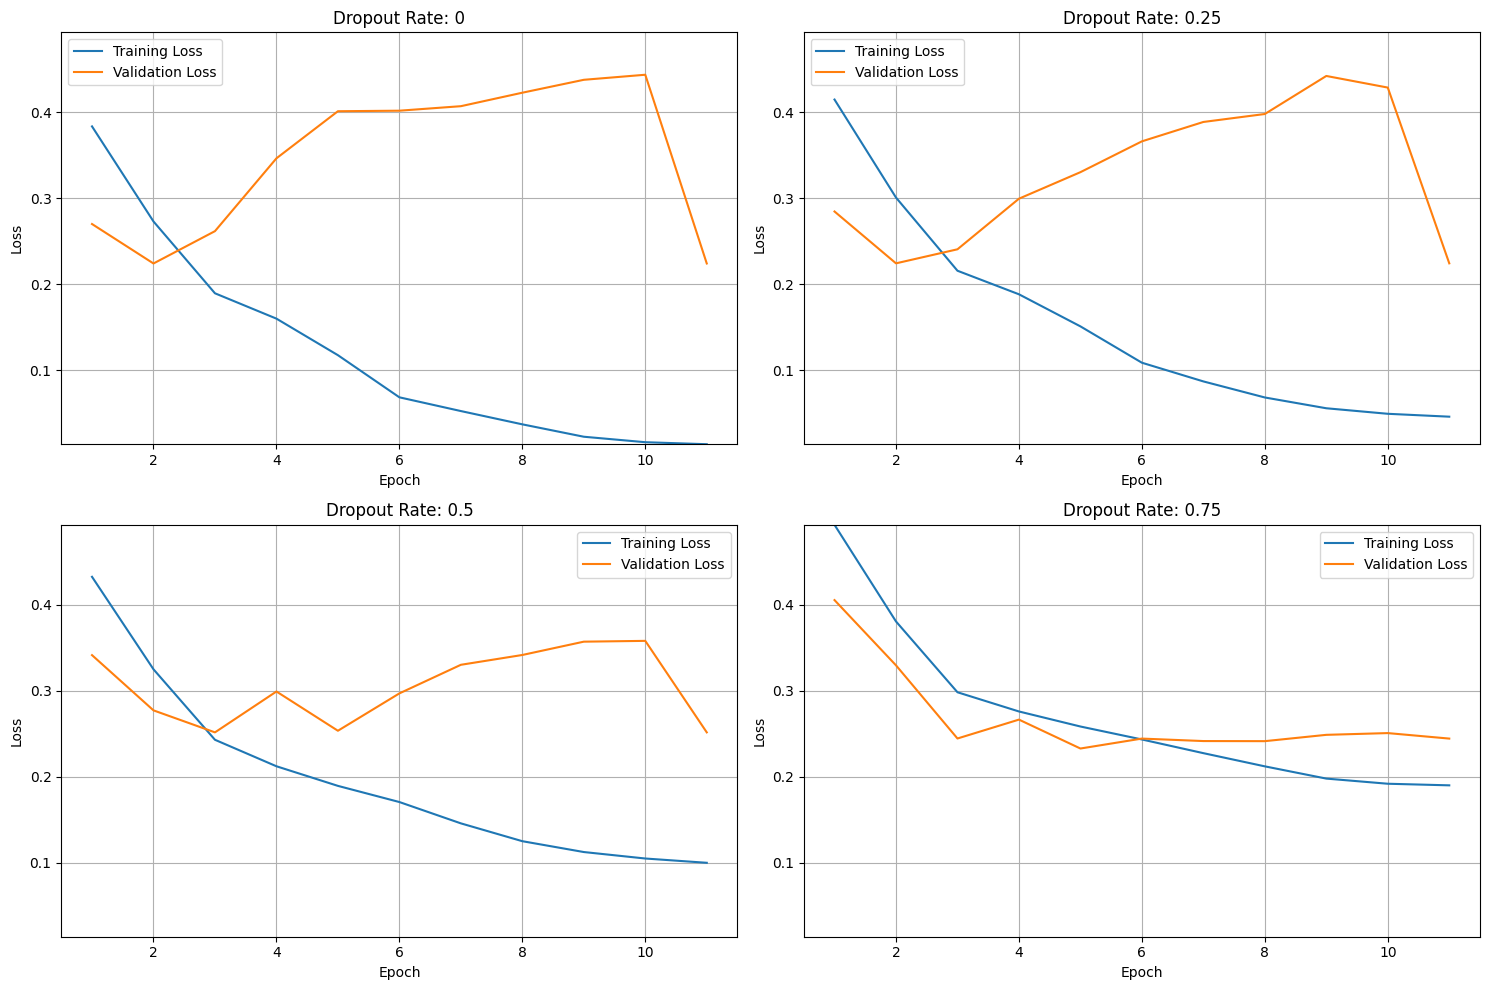


Summary of Results:

Dropout Rate: 0
Final Training Loss: 0.0141
Final Validation Loss: 0.2241
F1 Score: 0.9092
Recall: 0.9100
Precision: 0.9089

Dropout Rate: 0.25
Final Training Loss: 0.0461
Final Validation Loss: 0.2243
F1 Score: 0.9114
Recall: 0.9120
Precision: 0.9110

Dropout Rate: 0.5
Final Training Loss: 0.1000
Final Validation Loss: 0.2516
F1 Score: 0.9008
Recall: 0.9040
Precision: 0.9033

Dropout Rate: 0.75
Final Training Loss: 0.1900
Final Validation Loss: 0.2443
F1 Score: 0.9054
Recall: 0.9060
Precision: 0.9051


In [ ]:
# Plotting the loss curves
plt.figure(figsize=(15, 10))

# Find the minimum number of epochs across all dropout rates
min_epochs = min(len(data['val_loss']) for data in results.values())

for i, (dropout, data) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)

    # Interpolate training loss to match the number of validation loss points
    train_loss = np.interp(np.linspace(0, len(data['train_loss'])-1, min_epochs),
                           np.arange(len(data['train_loss'])),
                           data['train_loss'])

    # Use only the first min_epochs points for validation loss
    val_loss = data['val_loss'][:min_epochs]

    epochs = range(1, min_epochs+1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Dropout Rate: {dropout}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Set the same y-axis limits for all subplots
y_min = min(min(data['train_loss'] + data['val_loss'][:min_epochs]) for data in results.values())
y_max = max(max(data['train_loss'] + data['val_loss'][:min_epochs]) for data in results.values())
for ax in plt.gcf().get_axes():
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print a summary of the results
print("\nSummary of Results:")
for dropout, data in results.items():
    print(f"\nDropout Rate: {dropout}")
    print(f"Final Training Loss: {data['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {data['val_loss'][-1]:.4f}")
    print(f"F1 Score: {data['metrics']['eval_f1']:.4f}")
    print(f"Recall: {data['metrics']['eval_recall']:.4f}")
    print(f"Precision: {data['metrics']['eval_precision']:.4f}")

## Step 6: Feature Engineering - Sentiment and Sarcasm Detection

We will add sentiment analysis and sarcasm detection as additional features to improve the model's ability to classify reviews. By introducing these features, we provide extra context that can be useful for classification tasks.

In [ ]:
from textblob import TextBlob
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import string

def preprocess_data(text: str) -> str:
    return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()

sarcasm_model = AutoModelForSequenceClassification.from_pretrained("helinivan/english-sarcasm-detector")
sarcasm_tokenizer = AutoTokenizer.from_pretrained("helinivan/english-sarcasm-detector")

def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

def get_sarcasm_score(text):
    tokenized_text = sarcasm_tokenizer([preprocess_data(text)], padding=True, truncation=True, max_length=256, return_tensors="pt")
    with torch.no_grad():
        output = sarcasm_model(**tokenized_text)
    probs = output.logits.softmax(dim=-1).tolist()[0]
    return probs[1]  # Probability of being sarcastic

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset

class CustomDatasetWithFeatures(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']
        self.labels = tokenized_data['labels']
        self.sentiment_scores = [get_sentiment_score(text) for text in tokenized_data['text']]
        self.sarcasm_scores = [get_sarcasm_score(text) for text in tokenized_data['text']]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx],
            'sentiment_score': torch.tensor(self.sentiment_scores[idx], dtype=torch.float),
            'sarcasm_score': torch.tensor(self.sarcasm_scores[idx], dtype=torch.float)
        }

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class DistilBertWithFeatures(nn.Module):
    def __init__(self, num_labels=2):
        super().__init__()
        self.num_labels = num_labels  # Add this line
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Linear(self.distilbert.config.hidden_size + 2, num_labels)
        self.dropout = nn.Dropout(0.1)
        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, sentiment_score, sarcasm_score, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use CLS token
        pooled_output = self.dropout(pooled_output)
        # Concatenate sentiment and sarcasm scores
        concat_output = torch.cat((pooled_output, sentiment_score.unsqueeze(1), sarcasm_score.unsqueeze(1)), dim=1)
        logits = self.classifier(concat_output)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {'loss': loss, 'logits': logits}

In [ ]:
from transformers import Trainer, TrainingArguments

def train_distilbert_with_features(train_dataset, valid_dataset, learning_rate=2e-5, num_epochs=10, batch_size=32):
    model = DistilBertWithFeatures(num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        fp16=True,
        report_to="tensorboard",
        logging_dir='./logs',
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_strategy="epoch",
        save_total_limit=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
    )

    train_result = trainer.train()
    eval_result = trainer.evaluate()

    return trainer, train_result, eval_result

In [ ]:
# Prepare datasets
train_dataset_original = CustomDataset(train_tokenized)
valid_dataset_original = CustomDataset(valid_tokenized)

train_dataset_with_features = CustomDatasetWithFeatures(train_tokenized)
valid_dataset_with_features = CustomDatasetWithFeatures(valid_tokenized)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.282308,0.890000,0.885483,0.889070,0.890000
2,0.413000,0.236094,0.910000,0.909679,0.909437,0.910000
3,0.212600,0.258141,0.902000,0.902114,0.902236,0.902000
4,0.138300,0.361375,0.886000,0.887127,0.888912,0.886000
5,0.138300,0.428803,0.884000,0.887314,0.897493,0.884000
6,0.072600,0.435668,0.896000,0.896000,0.896000,0.896000
7,0.040400,0.442967,0.890000,0.888481,0.888028,0.890000
8,0.027000,0.442343,0.890000,0.890377,0.890830,0.890000
9,0.023000,0.458258,0.898000,0.896591,0.896265,0.898000
10,0.023000,0.469812,0.886000,0.886132,0.886273,0.886000


Training Loss: 0.1187798231462889
Evaluation results: {'eval_loss': 0.23609435558319092, 'eval_accuracy': 0.91, 'eval_f1': 0.9096785566473014, 'eval_precision': 0.9094367588932808, 'eval_recall': 0.91, 'eval_runtime': 5.3347, 'eval_samples_per_second': 93.725, 'eval_steps_per_second': 2.999, 'epoch': 10.0}


ValueError: too many values to unpack (expected 3)

In [ ]:
#Train original DistilBERT
original_trainer, original_train_result, original_eval_result, original_loss_history = train_distilbert_model(
    train_dataset_original, valid_dataset_original
)

# Train DistilBERT with additional features
feature_trainer, feature_train_result, feature_eval_result = train_distilbert_with_features(
    train_dataset_with_features, valid_dataset_with_features
)

# Compare results
print("Original DistilBERT results:")
print(f"F1 = {original_eval_result['eval_f1']:.4f}, Recall = {original_eval_result['eval_recall']:.4f}, Precision = {original_eval_result['eval_precision']:.4f}")

print("\nDistilBERT with additional features results:")
print(f"F1 = {feature_eval_result['eval_f1']:.4f}, Recall = {feature_eval_result['eval_recall']:.4f}, Precision = {feature_eval_result['eval_precision']:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.304922,0.866000,0.853555,0.873726,0.866000
2,0.386300,0.228133,0.914000,0.913899,0.913807,0.914000
3,0.205000,0.253544,0.914000,0.914850,0.916390,0.914000
4,0.145400,0.323569,0.900000,0.899271,0.898859,0.900000
5,0.145400,0.406426,0.890000,0.892528,0.899202,0.890000
6,0.071700,0.415624,0.898000,0.898795,0.899999,0.898000
7,0.040800,0.408237,0.894000,0.893621,0.893320,0.894000
8,0.027500,0.435778,0.898000,0.898350,0.898776,0.898000
9,0.019700,0.446039,0.898000,0.896591,0.896265,0.898000
10,0.019700,0.460047,0.898000,0.898350,0.898776,0.898000


Training Loss: 0.11500670396828953
Evaluation results: {'eval_loss': 0.25354382395744324, 'eval_accuracy': 0.914, 'eval_f1': 0.9148503422665653, 'eval_precision': 0.9163904494382022, 'eval_recall': 0.914, 'eval_runtime': 5.0689, 'eval_samples_per_second': 98.641, 'eval_steps_per_second': 3.157, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.295531,0.870000,0.858524,0.877206,0.870000
2,0.373400,0.217560,0.914000,0.913041,0.912823,0.914000
3,0.196800,0.250112,0.902000,0.901161,0.900757,0.902000
4,0.129200,0.393683,0.888000,0.883211,0.887103,0.888000
5,0.129200,0.377139,0.902000,0.902114,0.902236,0.902000
6,0.073600,0.478103,0.888000,0.886301,0.885872,0.888000
7,0.035700,0.502914,0.898000,0.898350,0.898776,0.898000
8,0.011700,0.506470,0.898000,0.897127,0.896685,0.898000
9,0.015100,0.519154,0.896000,0.894422,0.894135,0.896000
10,0.015100,0.527748,0.890000,0.890377,0.890830,0.890000


Original DistilBERT results:
F1 = 0.9149, Recall = 0.9140, Precision = 0.9164

DistilBERT with additional features results:
F1 = 0.9130, Recall = 0.9140, Precision = 0.9128


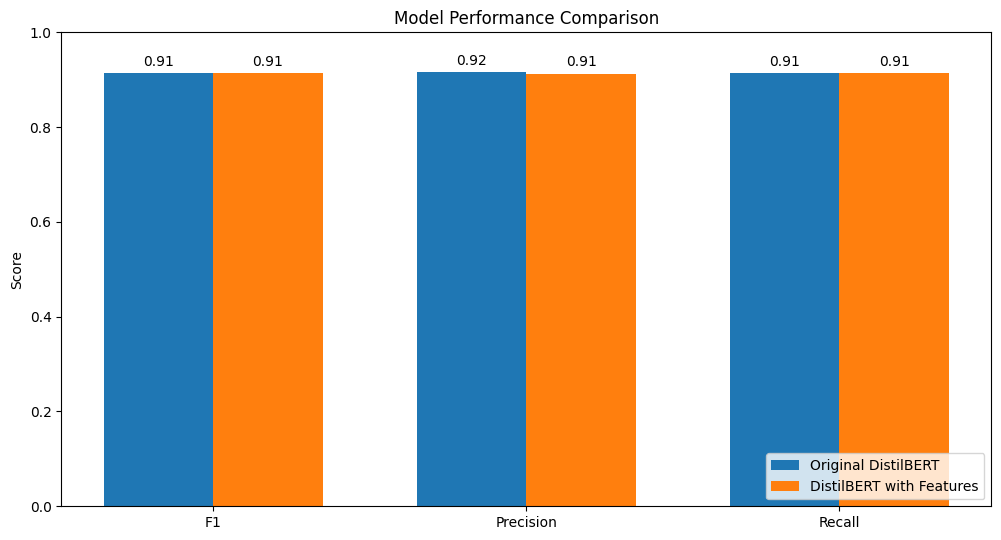

Original DistilBERT results:
F1 = 0.9149, Precision = 0.9164, Recall = 0.9140

DistilBERT with additional features results:
F1 = 0.9130, Precision = 0.9128, Recall = 0.9140


In [ ]:
import matplotlib.pyplot as plt

metrics = ['F1', 'Precision', 'Recall']
model_results = {
    'Original DistilBERT': {
        'f1': original_eval_result['eval_f1'],
        'precision': original_eval_result['eval_precision'],
        'recall': original_eval_result['eval_recall']
    },
    'DistilBERT with Features': {
        'f1': feature_eval_result['eval_f1'],
        'precision': feature_eval_result['eval_precision'],
        'recall': feature_eval_result['eval_recall']
    }
}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35
multiplier = 0

for model, results in model_results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [results['f1'], results['precision'], results['recall']],
                   width, label=model)
    ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)  # Assuming scores are between 0 and 1

# Add some space at the top of the plot for the labels
plt.subplots_adjust(top=0.9)

plt.show()

# Print the exact values
print("Original DistilBERT results:")
print(f"F1 = {original_eval_result['eval_f1']:.4f}, Precision = {original_eval_result['eval_precision']:.4f}, Recall = {original_eval_result['eval_recall']:.4f}")

print("\nDistilBERT with additional features results:")
print(f"F1 = {feature_eval_result['eval_f1']:.4f}, Precision = {feature_eval_result['eval_precision']:.4f}, Recall = {feature_eval_result['eval_recall']:.4f}")

## Conclusion

In this workshop, we compared the performance of BERT, DistilBERT, and LSTM models using various data sizes, hyperparameters, and dropout rates. We also explored how feature engineering with sentiment and sarcasm detection can improve performance.

By the end, we demonstrated the importance of:

    - Proper model selection for the task at hand.
    - Hyperparameter tuning for maximizing performance.
    - Feature engineering as a way to improve model robustness.

This comprehensive approach allows us to build more efficient and effective NLP models.